## Exercises

### 1. Feature importance
ML methods like Random Forest-based classifier can indicate the relative importance of each attribute (feature) for making accurate predictions. Display these importance scores next to their corresponding attribute names .

In [1]:
# Load data (not necessary if you ran the full notebook)
import pandas as pd
import numpy as np
data = pd.read_csv('PS0/data.csv')

# You can use boolean masks to select all column names matching a criteria
features_mean = data.columns[np.array([i[-5:] == '_mean' for i in data.columns])] 

# first, we split the variables of the data set in predictors (X) and target (y) 
X = data.loc[:, features_mean] # note we use only the 'mean' features as predictors
y = data.loc[:,'diagnosis']

# second, we split the data set into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_ctrain = X_train.copy()

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaled_features = sc.fit_transform(X_ctrain[features_mean].values)
X_ctrain[features_mean] = scaled_features

In [3]:
# Use CV to fit RF (not necessary if you ran the full notebook)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

grid_param_1 = [3, 10, 30]
grid_param_2 = [2, 3, 4]

param_grid = {'n_estimators': grid_param_1, 'max_features': grid_param_2}
forest_cls = RandomForestClassifier()

grid_search = GridSearchCV(forest_cls, param_grid, cv=5, #iid = False,
                           scoring='accuracy', return_train_score=True)

grid_search.fit(X_ctrain, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': [2, 3, 4],
                         'n_estimators': [3, 10, 30]},
             return_train_score=True, scoring='accuracy')

#### Solution:

In [4]:
# How to extract the feature important score
feature_importances = grid_search.best_estimator_.feature_importances_
# Print importances inside of a loop, note that Xc_train columns are in the same order as feature_means
# because of how it was constructed. 
for name, importance in zip(features_mean, grid_search.best_estimator_.feature_importances_):
    # Use format to print to a specific precision
    print('{} importance: {:.4f}'.format(name, importance))

radius_mean importance: 0.1018
texture_mean importance: 0.0582
perimeter_mean importance: 0.1325
area_mean importance: 0.0795
smoothness_mean importance: 0.0235
compactness_mean importance: 0.0411
concavity_mean importance: 0.2090
concave points_mean importance: 0.3178
symmetry_mean importance: 0.0208
fractal_dimension_mean importance: 0.0158


### 2. Support Vector Machine classifier
Try a Support Vector Machine classifier (sklearn.svm.SVC), with various hyper‐parameters such as kernel="linear" (with various values for the C hyperparameter) or kernel="rbf" (with various values for the C and gamma hyperparameters). Don’t worry about what these hyperparameters mean for now. How does the best SVC predictor perform? 

Plot the results using seaborn.lineplot (Hint: seaborn is very sensitive to input data type, use the .astype method to convert inputs to floating point values (dtype = 'float') if you run into problems). 

(Some confusion might arise from which data set to use: X/X_train/Xc_train)

#### Solution:

In [6]:
from sklearn.svm import SVC
param_grid_svc = {'C': [0.1, 1, 10, 100, 1000],  
                  'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                  'kernel': ['rbf']}  

svc_cls = SVC()
grid_search_svc = GridSearchCV(svc_cls, param_grid_svc, cv=5, ##iid = False,
                               scoring='accuracy', return_train_score=True)
grid_search_svc.fit(X_ctrain, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             return_train_score=True, scoring='accuracy')

In [7]:
column_names = ['param_C', 'param_gamma', 'param_kernel', 'mean_test_score', 'std_test_score']
search_data = pd.DataFrame(np.array([grid_search_svc.cv_results_[i] for i in column_names]).transpose(), columns = column_names)
search_data.mean_test_score = search_data.mean_test_score.astype('float')
search_data.param_C = search_data.param_C.astype('float')
search_data.param_gamma = search_data.param_gamma.astype('float')

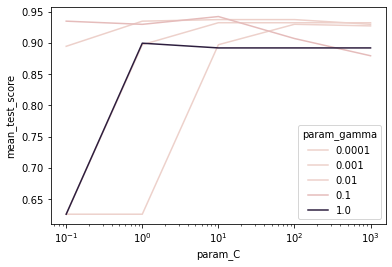

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.lineplot(x = 'param_C', y = 'mean_test_score', hue = 'param_gamma', data = search_data)
# Use logarithmic scale for SVC parameters
ax.set(xscale="log")
plt.show()

### 3. Randomized parameter search
Try replacingGridSearchCV with RandomizedSearchCV for the Support Vector machine from the previous exercise or the RandomForestClassifier from section 7. 

(Hint: use scipy.stats uniform, loguniform or randint distributions for the parameters). 

Visualize the results using seaborn (e.g. a scatterplot).

#### Solution:

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import loguniform
param_dist_svc = {'C': loguniform(0.1, 1000),  
                  'gamma': loguniform(0.0001, 1)}  

svc_cls = SVC(kernel = 'rbf')
random_search_svc = RandomizedSearchCV(svc_cls, param_dist_svc, cv=5, #iid = False,
                                       scoring='accuracy', return_train_score=True, 
                                       n_iter = 100)
random_search_svc.fit(X_ctrain, y_train)

RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=100,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc458be7850>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fc47ae21d10>},
                   return_train_score=True, scoring='accuracy')

In [11]:
# Make a plottable DataFrame
column_names = ['param_C', 'param_gamma', 'mean_test_score', 'std_test_score']
search_data = pd.DataFrame(np.array([random_search_svc.cv_results_[i] for i in column_names]).transpose(), columns = column_names)
#search_data.param_C = search_data.param_C.astype('float')
search_data.mean_test_score = search_data.mean_test_score.astype('float')
search_data.param_C = search_data.param_C.astype('float')
search_data.param_gamma = search_data.param_gamma.astype('float')

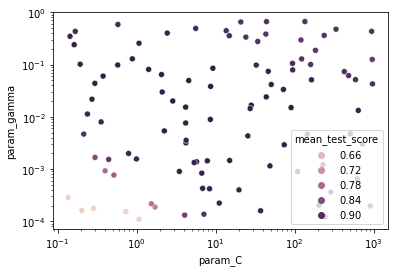

In [12]:
# Plot with seaborn.scatterplot
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.scatterplot(x = 'param_C', y = 'param_gamma', hue = 'mean_test_score', data = search_data)
# Use logarithmic scale for SVC parameters
ax.set(xscale = "log", yscale = "log")
plt.show()

### 4. Indian liver patient dataset
i) Download another data set (https://archive.ics.uci.edu/ml/datasets/ILPD+%28Indian+Liver+Patient+Dataset%29) and import it into python. 

ii) Process the data (cleaning, splitting and scaling). You may ignore the gender of the patients. 

iii) Predict disease status using any classifier you prefer. 

iv) Report the accuracy of your predictions. Did you notice any issues. 

#### Solution:

Looking at the .csv file in notepad (or Excel) we notice that the column names are missing so we 
have to give them manually based on the description on the website. 
Note that we also have to tell Pandas not to interpret the first data row 
as column names. 

The info method shows the count of non-missing values and A/G Ratio (Albumin and Globulin Ratio) is the only one with a different number. 

In [1]:
import pandas as pd
data_ilpd = pd.read_csv('PS1/ilpd.csv', header = None, names = ['Age','Gender','TB','DB','Alkphos','Sgpt','Sgot','TP','ALB','A/G','label'])
data_ilpd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Age      583 non-null    int64  
 1   Gender   583 non-null    object 
 2   TB       583 non-null    float64
 3   DB       583 non-null    float64
 4   Alkphos  583 non-null    int64  
 5   Sgpt     583 non-null    int64  
 6   Sgot     583 non-null    int64  
 7   TP       583 non-null    float64
 8   ALB      583 non-null    float64
 9   A/G      579 non-null    float64
 10  label    583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


Sometimes when using data from repositories you need to interpret the description of the attributes to figure out what the target variable is. 
We can check the distribution and check the page to infer that "1" corresponds to liver patient and "2" corresponds to non-liver patient. 

In [2]:
data_ilpd['label'].value_counts()

1    416
2    167
Name: label, dtype: int64

In [3]:
data_ilpd.drop(labels = 'Gender', axis = 1, inplace = True)

In [4]:
data_ilpd[~data_ilpd['A/G'].isnull()].shape

(579, 10)

Since we only had 4 missing values out of 583 in one of the columns, you could remove those rows or the column. 
If you chose to use imputation, ideally you would do it after splitting the data (not required this time). Here is an example using *sklearn.SimpleImputer*.

In [5]:
# Split to train and test sets (modified copy from section 4)
from sklearn.model_selection import train_test_split
X2_train, X2_test, y2_train, y2_test = train_test_split(data_ilpd.loc[:, data_ilpd.columns != 'label'], 
                                                    data_ilpd.loc[:, data_ilpd.columns == 'label'], 
                                                    test_size = 0.3, random_state = 0)

In [6]:
import numpy as np
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X2_train)
X2_train.info()
X2_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408 entries, 271 to 559
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Age      408 non-null    int64  
 1   TB       408 non-null    float64
 2   DB       408 non-null    float64
 3   Alkphos  408 non-null    int64  
 4   Sgpt     408 non-null    int64  
 5   Sgot     408 non-null    int64  
 6   TP       408 non-null    float64
 7   ALB      408 non-null    float64
 8   A/G      405 non-null    float64
dtypes: float64(5), int64(4)
memory usage: 31.9 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 175 entries, 246 to 395
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Age      175 non-null    int64  
 1   TB       175 non-null    float64
 2   DB       175 non-null    float64
 3   Alkphos  175 non-null    int64  
 4   Sgpt     175 non-null    int64  
 5   Sgot     175 non-null    int64  
 6   TP       1

In [7]:
# The transform returns a numpyp.array which we can insert into the DataFrame columns
# Or you could use the numpyp.array from this point onward
X2_train[:] = imp_mean.transform(X2_train) 
X2_test[:] = imp_mean.transform(X2_test)
X2_train.info()
X2_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408 entries, 271 to 559
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Age      408 non-null    float64
 1   TB       408 non-null    float64
 2   DB       408 non-null    float64
 3   Alkphos  408 non-null    float64
 4   Sgpt     408 non-null    float64
 5   Sgot     408 non-null    float64
 6   TP       408 non-null    float64
 7   ALB      408 non-null    float64
 8   A/G      408 non-null    float64
dtypes: float64(9)
memory usage: 31.9 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 175 entries, 246 to 395
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Age      175 non-null    float64
 1   TB       175 non-null    float64
 2   DB       175 non-null    float64
 3   Alkphos  175 non-null    float64
 4   Sgpt     175 non-null    float64
 5   Sgot     175 non-null    float64
 6   TP       175 non-nul

We could also check the distributions for outliers but with the missing values removed we can now use the scaler without issues.

In [8]:
# Feature scaling (modified copy from section 5)
from sklearn.preprocessing import StandardScaler
X2_ctrain = X2_train.copy()
X2_ctest = X2_test.copy()
sc = StandardScaler()
# We could actually give gender to the scaler by substituting one gender with 1 and the other with 0. 
# The scaler would then translate those into some other values, one positive and one negative with the 
# values being dependent on the fraction of each gender in the data.
# But for now we will just drop it.
X2_ctrain = sc.fit_transform(X2_ctrain.loc[:, X2_ctrain.columns != "Gender"].values)
X2_ctest = sc.transform(X2_ctest.loc[:, X2_ctest.columns != "Gender"].values)

In [9]:
# Create a Logistic Regression instance (code from section 6)
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression(random_state = 0, solver = 'lbfgs', penalty = 'none')
logistic_model.fit(X2_ctrain, y2_train['label'])

LogisticRegression(penalty='none', random_state=0)

In [10]:
# Make predictions and report accuracy
from sklearn import metrics
y2_train_pred = logistic_model.predict(X2_ctrain)
y2_test_pred = logistic_model.predict(X2_ctest)
acc_train = metrics.accuracy_score(y2_train, y2_train_pred)
acc_test = metrics.accuracy_score(y2_test, y2_test_pred)
print('Training accuracy: {} \nTest accuracy: {}'.format(acc_train, acc_test))

Training accuracy: 0.7549019607843137 
Test accuracy: 0.6914285714285714


If you explored the data you may have noticed that there are issues with the data quality which lead to poor machine learning performance even when tuning the algorithms. 
You will learn in later sessions how to spot these issues. But at this stage we should just note that machine learning cannot solve every problem. There was also a slight imbalance of the classes with 416 cases labeled "1" and 167 labeled "2", so for this data set assuming every patient has the disease yields around 71% accuracy. But of course, such a model is not useful in practice ...